In [29]:
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from Utils.functions import *
from Utils.algorithms import *
from collections import deque
import seaborn as sns 

In [21]:
def normalize_columns(X):
    return X / np.linalg.norm(X, axis=0, keepdims=True)

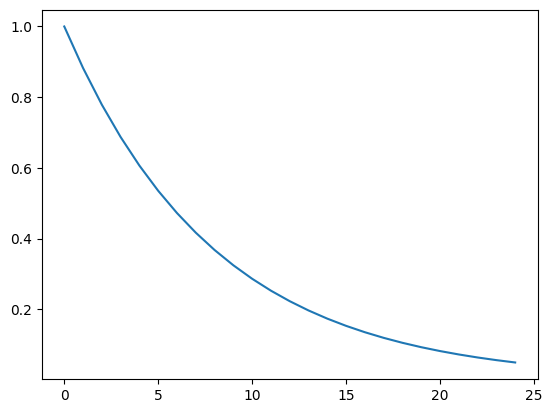

In [98]:
P = 25

beta = 0.95
eigs = np.asarray([np.exp(-beta * k) for k in range(P)])

alpha = 0.2         # % of P that u want to have useful eigenvalues
eigs = np.asarray([1/(1+i/(alpha*P)) for i in range(P)])

eigenvalues = np.exp(-np.linspace(0, 3, P))
Q, _ = np.linalg.qr(np.random.randn(P, P))  # orthogonal basis
sigma = Q @ np.diag(eigenvalues) @ Q.T  

plt.plot(eigenvalues)

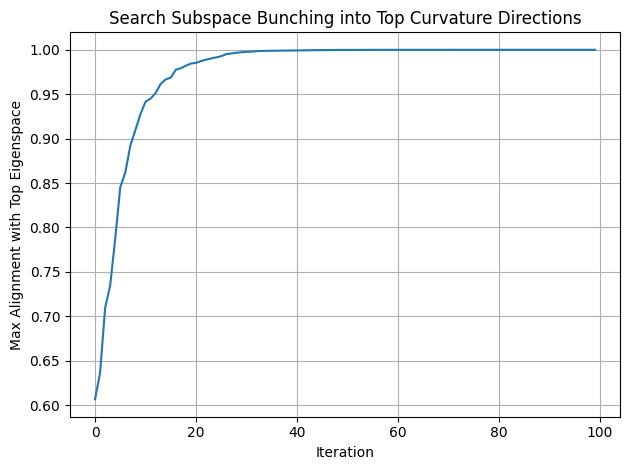

In [103]:
from numpy.linalg import svd, qr

# Parameters
P = 50          # ambient dimension
K = 10          # sketch size
f = K // 2      # number of structured directions
N_iter = 100    # number of iterations

# Create sigma with *strong curvature contrast*
eigs = np.concatenate([
    np.linspace(10, 5, f),  # top eigenvalues
    np.linspace(1, 0.1, P - f)  # rest
])
Q, _ = qr(np.random.randn(P, P))  # orthogonal basis
sigma = Q @ np.diag(eigs) @ Q.T   # curvature matrix

# Compute true top eigenspace
U_true, _, _ = svd(sigma)
U_top = U_true[:, :f]  # top eigendirections

# Initialize V randomly
V = np.random.randn(P, K)
V, _ = qr(V)

alignment_history = []

for n in range(N_iter):
    # Subspace overlap: how well V spans top eigenspace
    proj = U_top.T @ V  # shape (f, K)
    svals = svd(proj, compute_uv=False)
    alignment_score = np.max(svals)  # use max singular value for sharper signal
    alignment_history.append(alignment_score)

    # Project curvature into current subspace and get top f directions
    c = V.T @ sigma @ V
    U, _, _ = svd(c)
    W = U[:, :f]
    Q_struct, _ = qr(V @ W)

    # Mix in exploration (random directions)
    F = np.random.randn(P, K - f)
    F, _ = qr(F)

    # Combine: structured + random
    V = np.hstack([Q_struct[:, :f], F[:, :K - f]])
    V, _ = qr(V)

# Plot
plt.plot(alignment_history)
plt.xlabel("Iteration")
plt.ylabel("Max Alignment with Top Eigenspace")
plt.title("Search Subspace Bunching into Top Curvature Directions")
plt.grid(True)
plt.tight_layout()
plt.show()



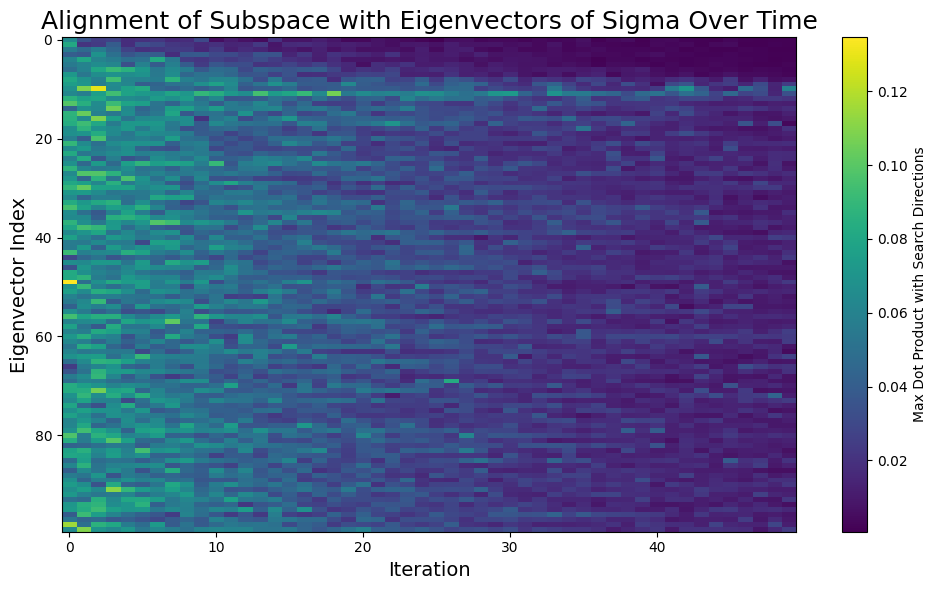

In [ ]:
from numpy.linalg import qr

# Parameters
P = 100          # ambient dimension
K = 20           # sketch size
f = K // 2       # number of structured directions
N_iter = 50      # number of iterations

alpha = 0.95         # % of P that u want to have useful eigenvalues
eigs = np.asarray([1/(1+i/(alpha*P)) for i in range(P)])

alpha = 1.991
eigs = np.asarray([1/(i+1)**alpha for i in range(P)])

beta = 0.5
#eigs = np.asarray([np.exp(-beta * k) for k in range(P)])


Q, _ = np.linalg.qr(np.random.randn(P, P))  # orthogonal basis
sigma = Q @ np.diag(eigs) @ Q.T  


# Compute true eigenvectors of sigma
U_true, _, _ = np.linalg.svd(sigma)

# Initialize V randomly
V, _ = qr(np.random.randn(P, P))
V = V[:, :K]            # Keep only K columns

# Store cosine similarity between each U_true[:, i] and V
alignment_matrix = np.zeros((P, N_iter))

for n in range(N_iter):
    # For each true eigenvector, compute max cosine similarity with V
    for i in range(P):
        u = U_true[:, i]
        dot_product = np.abs(u.T @ V)                       # find dot product of u with all columns of V
        alignment_matrix[i, n] = np.max(dot_product)        # take the aligment score to be that of the v that overlaps most with u 

    # Structured directions (top 50% of tangents are eigenvectors)
    c = V.T @ sigma @ V
    U, _, _ = np.linalg.svd(c)
    W = U[:, :f]
    R, _ = qr(V @ W)

    # Random directions
    F, _ = qr(np.random.randn(P, P))
    F = F[:, :K-f] 

    V = np.hstack([R, F])   # Combine structured and random directions
    V, _ = qr(V)            # Re-orthogonalize


# Plot heatmap with flipped y indices
plt.figure(figsize=(10, 6))
plt.imshow(alignment_matrix, aspect='auto', cmap='viridis', origin='lower')
plt.colorbar(label='Max Dot Product with Search Directions')
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Eigenvector Index', fontsize=14)
plt.title('Alignment of Subspace with Eigenvectors of Sigma Over Time', fontsize=18)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [ ]:
K = 5

U_true, _, _ = jnp.linalg.svd(sigma)
U_norm = normalize_columns(U_true)

f = int(0.5 * K)        # keep last f columns of U

alignment_history = []
V = np.random.randn(P, K)        # random matrix to start off

N_iter = 100
for n in range(N_iter):
    this_iter = []
    for p in range(P):
        this_iter.append(np.abs(U_norm[:, p].T @ V[:, 0]))
    alignment_history.append(this_iter)
    c = V.T @ sigma @ V
    
    # get eigenvalues and eigenvectors
    U, _, _ = jnp.linalg.svd(c)
    W = U[:, :f] 
    Q, _ = np.linalg.qr(V @ W)
    R = Q
    F = np.random.randn(P, K-f)        # choose F's randomly
    V = np.column_stack((R, F))
    
alignment_history = np.array(alignment_history).T
alignment_history.shape

(25, 100)

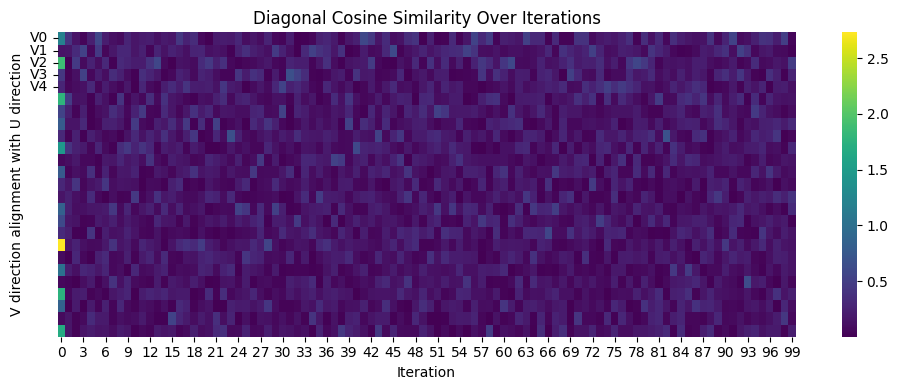

In [97]:
plt.figure(figsize=(10, 4))
sns.heatmap(alignment_history, annot=False, cmap="viridis", cbar=True,
            yticklabels=[f"V{i}" for i in range(K)])
plt.xlabel("Iteration")
plt.ylabel("V direction alignment with U direction")
plt.title("Diagonal Cosine Similarity Over Iterations")
plt.tight_layout()
plt.show()

In [88]:
K = 5

U_true, _, _ = jnp.linalg.svd(sigma)
U_norm = normalize_columns(U_true)

f = int(0.5 * K)        # keep last f columns of U

alignment_history = []
V = np.random.randn(P, K)        # random matrix to start off

N_iter = 1000
for n in range(N_iter):
    V_norm = normalize_columns(V)

    #sims = np.sum(np.abs(U_norm.T @ V_norm), axis=1) / K

    #cosine_sim = np.abs(np.sum(V_norm * U_top_norm, axis=0))  # elementwise dot on columns
    #alignment_history.append(sims)

    c = V.T @ sigma @ V
    
    # get eigenvalues and eigenvectors
    U, s, _ = jnp.linalg.svd(c)
    W = U[:, :f] 
    Q, _ = np.linalg.qr(V @ W)
    R = Q
    F = np.random.randn(P, K-f)        # choose F's randomly
    V = np.column_stack((R, F))

    sims = np.sum(np.abs(U_norm.T @ R), axis=1) 
    if n % 10 == 0:
        alignment_history.append(sims)
    
alignment_history = np.array(alignment_history).T  # shape: (K, N_iter)
print(alignment_history.shape)

(25, 100)


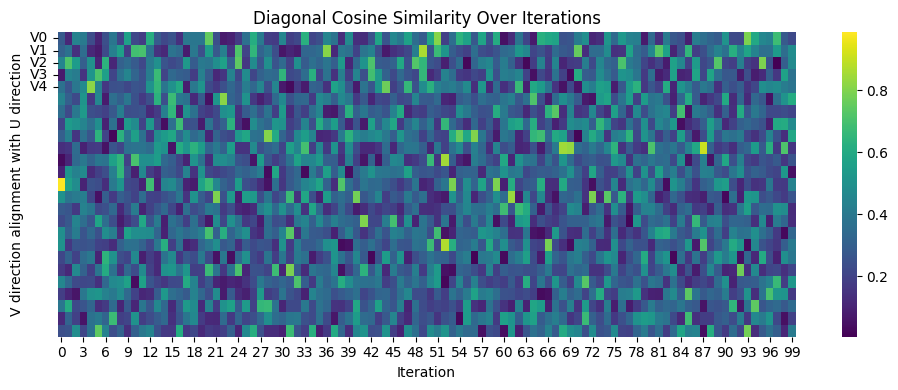

In [89]:
plt.figure(figsize=(10, 4))
sns.heatmap(alignment_history, annot=False, cmap="viridis", cbar=True,
            yticklabels=[f"V{i}" for i in range(K)])
plt.xlabel("Iteration")
plt.ylabel("V direction alignment with U direction")
plt.title("Diagonal Cosine Similarity Over Iterations")
plt.tight_layout()
plt.show()

In [ ]:
K = 4
f = int(0.5 * K)        # keep last f columns of U

N = 60

stop_points = [2, truncation, 30, 50]
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.flatten()


V_l = np.random.randn(n_left, K)
V_r = np.random.randn(n_right, K)

print(V_l.shape)        # should by 13 x 4

previous_vs = deque(maxlen=truncation)

for n in range(N):
    print(f'Iteration {n}')
        
    # sketch
    c_left = V_l.T @ G_l @ V_l
    U, S, _ = jnp.linalg.svd(c_left)
    W = U[:, :f]                       # keep last f columns, 4 x 2
    Q, _ = np.linalg.qr(V_l @ W)
    R = Q
    F = np.random.randn(n_left, K-f)        # choose F's randomly again
    V_l = np.column_stack((R, F))

    c_right = V_r.T @ G_r @ V_r
    U, S, _ = jnp.linalg.svd(c_right)
    W = U[:, :f]                       
    Q, _ = np.linalg.qr(V_r @ W)
    R = Q
    F = np.random.randn(n_right, K-f)       
    V_r = np.column_stack((R, F)) 

    # look at firt column of V_l and V_r
    v = np.kron(V_l[:, 0], V_r[:, 0])
    previous_vs.append(v)

    dot_prods = []
    for i in range(P):
        u_i = eigvecs[:, i]     # ith eigenvector
        dot_count = 0
        for vj in previous_vs:
            dot_count += abs(float(u_i.T @ vj))
        avg_dot_prod = dot_count / len(previous_vs)
        dot_prods.append(avg_dot_prod)
    
    for idx, stop in enumerate(stop_points):
        if n == stop:
            axs[idx].plot(dot_prods)
            smoothed_dot_prods = np.convolve(dot_prods, np.ones(10)/10, mode='valid')
            axs[idx].plot(smoothed_dot_prods)
            axs[idx].set_title(f'After {stop} iterations')
            axs[idx].set_xlabel('ith eigenvector')
    
    
plt.tight_layout()
plt.show()

    

In [2]:
n_left = 13
n_right = 9
P = n_left*n_right

In [3]:
# power law
alpha = 0.02         # % of P that u want to have useful eigenvalues

# Choose eigenspectrum
eigs_left = [1/(1+i/(alpha*n_left)) for i in range(n_left)]
eigs_right = [1/(1+i/(alpha*n_right)) for i in range(n_right)]

G = [initialise_g(n_left, n_right, jax.random.PRNGKey(40), eigs_left=eigs_left, eigs_right=eigs_right)]
G_l = G[0]["left"] @ G[0]["left"].T
G_r = G[0]["right"] @ G[0]["right"].T
sigma = KP_sum(G)

# eigenvalue decomposition of G, P eigenvalues and P eigenvectors, does it in decsending order
eigvecs, eigvals, _ = jnp.linalg.svd(sigma)

Is numpy KP same as vec(v_r @ v_l.T)?
True
Is numpy KP same as rowvec(v_l @ v_r.T)?
True


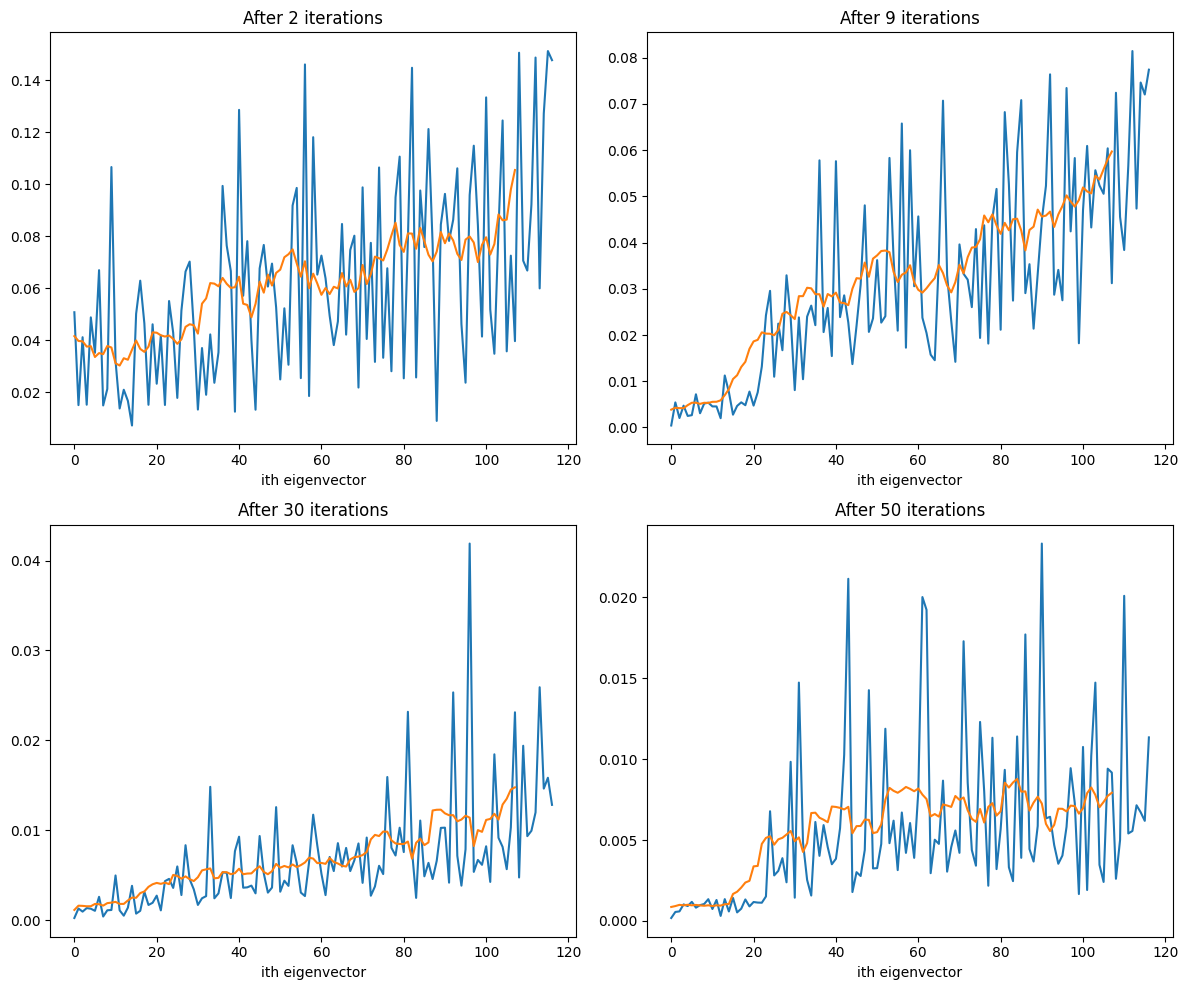

In [4]:
truncation = min(n_left, n_right)

previous_vs = deque(maxlen=truncation)  

overall_dot_prods = []

stop_points = [2, truncation, 30, 50]
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.flatten()

N = 101
for n in range(N):
    V_list = []                # holds conjugate search directions for each iteration

    v_l = np.random.randn(n_left, 1)
    v_r = np.random.randn(n_right, 1)
    v_l /= np.linalg.norm(v_l)
    v_r /= np.linalg.norm(v_r)

    if previous_vs:
        for vj in previous_vs:
            vj_l = vj["left"]
            vj_r = vj["right"]
                
            num = v_l.T @ G_l @ vj_l
            denom = vj_l.T @ G_l @ vj_l
            v_l -= (num / denom) * vj_l

            num = v_r.T @ G_r @ vj_r
            denom = vj_r.T @ G_r @ vj_r
            v_r -= (num / denom) * vj_r
            
    v = {"left": v_l, "right": v_r}
        
    previous_vs.append(v)
    if n == 0:
        print('Is numpy KP same as vec(v_r @ v_l.T)?')
        print(np.allclose(np.kron(v_l, v_r), vec(v_r @ v_l.T).reshape(-1, 1)))
        print('Is numpy KP same as rowvec(v_l @ v_r.T)?')
        print(np.allclose(np.kron(v_l, v_r), row_vec(v_l @ v_r.T).reshape(-1, 1)))
    v_formed = vec(v_r @ v_l.T)

    dot_prods = []
    for i in range(P):
        u_i = eigvecs[:, i]     # ith eigenvector
        dot_count = 0
        for vj in previous_vs:
            v_formed = vec(vj["right"] @ vj["left"].T)
            dot_count += abs(float(u_i.T @ v_formed))
        avg_dot_prod = dot_count / len(previous_vs)
        dot_prods.append(avg_dot_prod)
    
    for idx, stop in enumerate(stop_points):
        if n == stop:
            axs[idx].plot(dot_prods)
            smoothed_dot_prods = np.convolve(dot_prods, np.ones(10)/10, mode='valid')
            axs[idx].plot(smoothed_dot_prods)
            axs[idx].set_title(f'After {stop} iterations')
            axs[idx].set_xlabel('ith eigenvector')
    
    

    V_list.append(v_formed) 

plt.tight_layout()
plt.show()


(13, 4)
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59


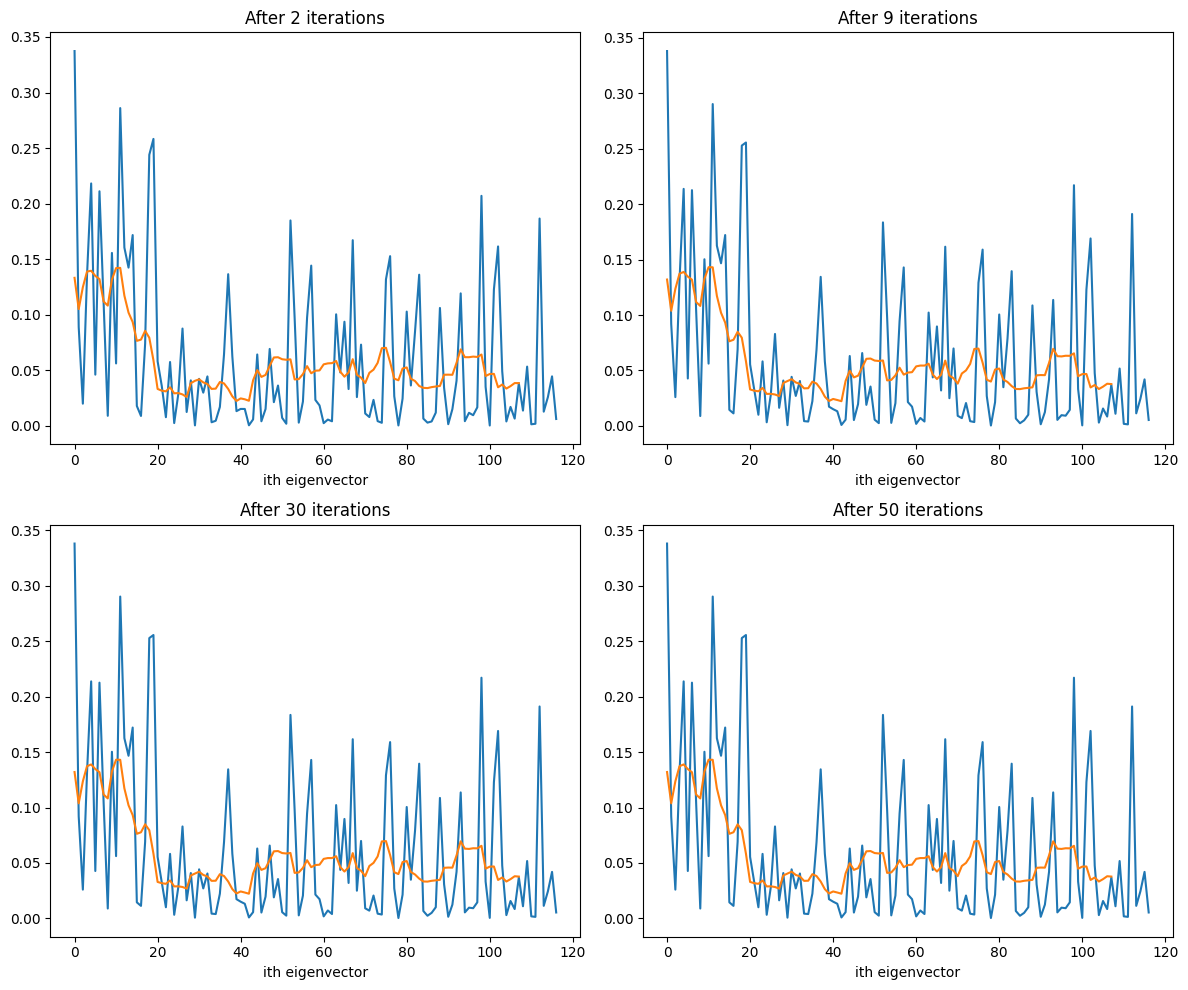

In [ ]:
K = 4
f = int(0.5 * K)        # keep last f columns of U

N = 60

stop_points = [2, truncation, 30, 50]
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.flatten()


V_l = np.random.randn(n_left, K)
V_r = np.random.randn(n_right, K)

print(V_l.shape)        # should by 13 x 4

previous_vs = deque(maxlen=truncation)

for n in range(N):
    print(f'Iteration {n}')
        
    # sketch
    c_left = V_l.T @ G_l @ V_l
    U, S, _ = jnp.linalg.svd(c_left)
    W = U[:, :f]                       # keep last f columns, 4 x 2
    Q, _ = np.linalg.qr(V_l @ W)
    R = Q
    F = np.random.randn(n_left, K-f)        # choose F's randomly again
    V_l = np.column_stack((R, F))

    c_right = V_r.T @ G_r @ V_r
    U, S, _ = jnp.linalg.svd(c_right)
    W = U[:, :f]                       
    Q, _ = np.linalg.qr(V_r @ W)
    R = Q
    F = np.random.randn(n_right, K-f)       
    V_r = np.column_stack((R, F)) 

    # look at firt column of V_l and V_r
    v = np.kron(V_l[:, 0], V_r[:, 0])
    previous_vs.append(v)

    dot_prods = []
    for i in range(P):
        u_i = eigvecs[:, i]     # ith eigenvector
        dot_count = 0
        for vj in previous_vs:
            dot_count += abs(float(u_i.T @ vj))
        avg_dot_prod = dot_count / len(previous_vs)
        dot_prods.append(avg_dot_prod)
    
    for idx, stop in enumerate(stop_points):
        if n == stop:
            axs[idx].plot(dot_prods)
            smoothed_dot_prods = np.convolve(dot_prods, np.ones(10)/10, mode='valid')
            axs[idx].plot(smoothed_dot_prods)
            axs[idx].set_title(f'After {stop} iterations')
            axs[idx].set_xlabel('ith eigenvector')
    
    
plt.tight_layout()
plt.show()

    

So np.kron is equivalent to doing vec(v_r @ v_l.T) which is same as doing row_vec(v_l @ v_r.T)